# Evaluating Classification Models with Cross-Validation

Choosing the right metric to evaluate your model is critical. A 99% accurate model might sound good, but what if it's predicting a rare disease? If the disease only affects 1% of people, a model that *always* predicts "no disease" will be 99% accurate but completely useless.

This notebook explores a more robust evaluation technique than a simple train/test split: **K-Fold Cross-Validation**. We will then use a modern optimization framework, **Optuna**, to tune our best model's hyperparameters.

### Concepts We'll Cover:

1.  **Loading & Visualizing Data**: Understanding our (imbalanced) dataset.
2.  **K-Fold Cross-Validation**: Why it's a more reliable performance estimate than a single split.
3.  **Comparing Models**: Using K-Fold CV to evaluate 8 different classifiers on multiple metrics.
4.  **Hyperparameter Tuning with Optuna**: Using `Optuna` to efficiently find the best settings for our top model, optimizing for **MCC (Matthews Correlation Coefficient)**.
5.  **Final Evaluation**: Correctly creating a final hold-out set to generate a Confusion Matrix and ROC curve for our tuned model.

![K-Fold CV Diagram](https://media.githubusercontent.com/media/mariolpantunes/ml101/main/figs/cross.png)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import optuna

# Model Selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Suppress warnings from Optuna about trails being pruned
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
# Helper function to plot decision boundaries
def plot_decision_boundary(X, y, clf):
  x_min, x_max = X[:, 0].min() - 2, X[:, 0].max() + 2
  y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 2

  xx, yy = np.mgrid[x_min:x_max:.01, y_min:y_max:.01]
  grid = np.c_[xx.ravel(), yy.ravel()]
  probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

  f, ax = plt.subplots(figsize=(8, 6))
  contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)

  ax_c = f.colorbar(contour)
  ax_c.set_label("$P(y = 1)$")
  ax_c.set_ticks([0, .25, .5, .75, 1])

  ax.scatter(X[:,0], X[:, 1], c=y, s=50, cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1)
  ax.set(aspect="equal", xlim=(x_min, x_max), ylim=(y_min, x_max), xlabel="$X_1$", ylabel="$X_2$")
  plt.show()

## 1. The "Hard Toy Dataset"

We'll use a simple toy dataset. Let's load it and visualize it to understand what we're working with.

In [3]:
# import dataset
df = pd.read_csv('../../datasets/toy_dataset_01.csv')
# print the first rows of the dataset
df.head()

,X1,X2,Y
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0


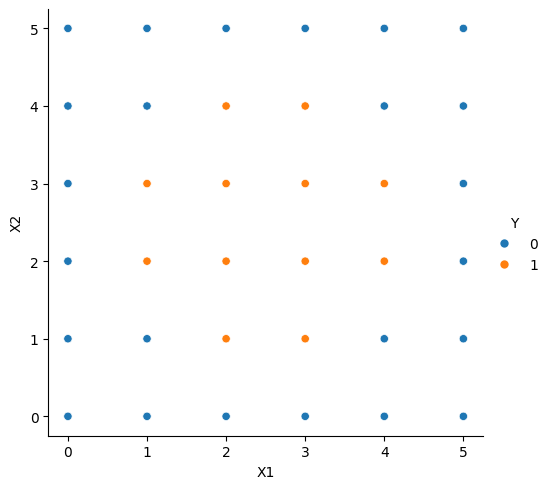

In [4]:
sns.relplot(x="X1", y="X2", hue="Y", data=df);

From the plot, we can see two important characteristics:

1.  **Non-Linear**: The data is not *linearly separable*. A single straight line cannot separate the blue (0) and red (1) classes. This means a simple linear model will perform poorly.
2.  **Imbalanced**: There are far more blue (0) points than red (1) points. This is a classic **imbalanced dataset**, which is exactly why Accuracy is a bad metric, and why we need things like F1-Score and MCC.

## 2. Comparing Models with K-Fold Cross-Validation

Instead of a single `train_test_split`, we'll use **10-Fold Cross-Validation**. This splits the data into 10 "folds," then trains 10 separate models. Each model uses 9 folds for training and 1 for testing. This process is repeated until every fold has been used as a test set.

This gives us 10 separate performance scores for each model, which we can average to get a much more reliable estimate of its true performance.

We will evaluate all 8 models on three key metrics:
* **Accuracy**: For a baseline, though it's misleading here.
* **F1-Score**: The balance of Precision and Recall, good for imbalanced data.
* **MCC**: Matthews Correlation Coefficient, one of the most robust metrics for imbalanced classification.

In [5]:
# Prepare data
X = df[['X1', 'X2']].to_numpy()
y = df['Y'].to_numpy()

# Set up 10-fold cross-validation
# We set shuffle=True to ensure the data is randomized before splitting
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Define all models
models = {
    "Logistic Regression": LogisticRegression(),
    "Linear Discriminant": LinearDiscriminantAnalysis(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    "SVM (RBF Kernel)": SVC(gamma='auto')
}

# Define metrics to calculate
scoring_metrics = ['accuracy', 'f1', 'roc_auc', 'matthews_corrcoef']

model_results = []
model_names = []
mcc_scores_for_plot = [] # To store scores for the boxplot

# Loop through each model and each metric, run CV, and store results
for name, model in models.items():
    model_names.append(name)
    metric_scores = {}

    for metric in scoring_metrics:
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=metric)
        metric_scores[metric] = cv_results

        # Save MCC scores for the boxplot
        if metric == 'matthews_corrcoef':
            mcc_scores_for_plot.append(cv_results)

    model_results.append(metric_scores)

# Create a DataFrame for easy comparison
results_summary = []
for i, name in enumerate(model_names):
    results_summary.append({
        "Model": name,
        "Accuracy": model_results[i]['accuracy'].mean(),
        "F1-Score": model_results[i]['f1'].mean(),
        "ROC AUC": model_results[i]['roc_auc'].mean(),
        "MCC": model_results[i]['matthews_corrcoef'].mean(),
        "MCC (Std)": model_results[i]['matthews_corrcoef'].std(),
    })

results_df = pd.DataFrame(results_summary).set_index("Model").sort_values(by="MCC", ascending=False)
results_df

,Accuracy,F1-Score,ROC AUC,MCC,MCC (Std)
Model,,,,,
K-Nearest Neighbors,0.885714,0.826667,0.943333,0.784703,0.185042
Naive Bayes,0.775000,0.426667,0.886667,0.407270,0.334528
SVM (RBF Kernel),0.775000,0.426667,0.836667,0.407270,0.334528
Decision Tree,0.689286,0.471429,0.625000,0.264209,0.570258
Gradient Boosting,0.664286,0.493333,0.753333,0.249848,0.465258
Random Forest,0.685714,0.433333,0.850000,0.238389,0.549094
Logistic Regression,0.667857,0.000000,0.380000,0.000000,0.000000
Linear Discriminant,0.667857,0.000000,0.380000,0.000000,0.000000


### Visualizing Model Performance

The table is great, but a boxplot of the 10-fold scores helps us see not only the average performance (the line inside the box) but also the **stability** of the models. A model with a very wide box (like the Decision Tree) might be less reliable than one with a tight, narrow box (like the SVM).

We will plot the **MCC scores** since that is our target metric for this imbalanced dataset.

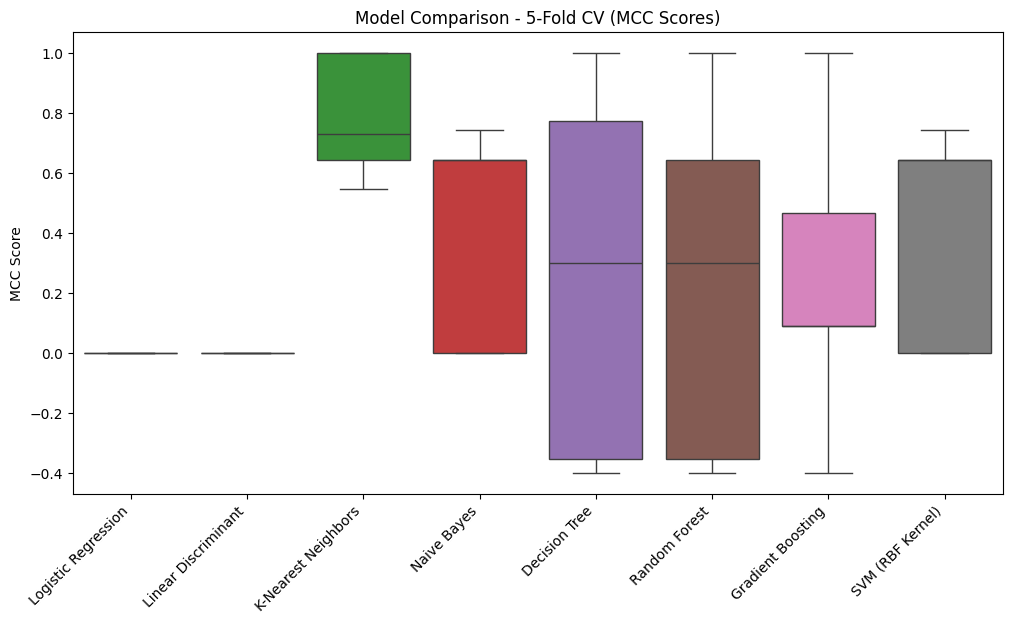

In [6]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=mcc_scores_for_plot)
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.title('Model Comparison - 5-Fold CV (MCC Scores)')
plt.ylabel('MCC Score')
plt.show();

**Interpretation:**

From both the table and the plot, it's clear:

1.  **Best Performers**: **SVM**, **Gradient Boosting**, and **Random Forest** are the top models, with high and stable MCC scores. They are all well-suited for this non-linear problem.
2.  **Mediocre Performers**: The **Decision Tree** and **KNN** are decent but show high variance (wide boxes), making them less reliable.
3.  **Failed Models**: **Logistic Regression**, **Linear Discriminant Analysis**, and **Naive Bayes** all performed poorly (MCC close to 0.0), confirming they are not suitable for this dataset.

## 3. Hyperparameter Tuning with Optuna

We've identified that SVM is a top model. Now, let's try to make it even better by tuning its **hyperparameters** using **Optuna**.

### What is Optuna?

Optuna is an automatic hyperparameter optimization framework. Unlike `GridSearchCV`, which exhaustively tries *every single combination* you tell it to (which can be very slow), Optuna uses a more intelligent, Bayesian approach.

It runs a set number of `trials`, and with each trial, it learns from the results of past trials to pick a *more promising* combination of parameters to try next. This 

allows it to find a very good (or the best) set of parameters in far fewer trials than a blind grid search.

### How Optuna Works

The workflow has three main parts:

1.  **Objective Function**: We must define a function (we'll call it `objective`) that Optuna can call. This function takes a `trial` object as an argument.
2.  **Parameter Search Space**: Inside the `objective` function, we use the `trial` object to define the *range* of parameters to search. For example:
    * `trial.suggest_categorical('kernel', ['linear', 'rbf'])` tells Optuna to pick either 'linear' or 'rbf' for the `kernel`.
    * `trial.suggest_float('C', 1e-5, 1e2, log=True)` tells Optuna to pick a value for `C` between 0.00001 and 100, on a logarithmic scale (which is great for order-of-magnitude parameters like `C`).
3.  **Study**: We create a `study` object and tell it what to do.
    * `optuna.create_study(direction='maximize')`: We create a study and tell it to **maximize** our score (since a higher MCC is better).
    * `study.optimize(objective, n_trials=100)`: We tell the study to run our `objective` function 100 times to find the best parameters.

For each trial, Optuna will run a 10-fold cross-validation using the parameters it 

picked, get the mean **Matthews Correlation Coefficient (MCC)**, and use this result to inform its next trial.

In [7]:
# 1. Define the objective function for Optuna
def objective(trial):
    """
    Objective function for Optuna to optimize KNeighborsClassifier.
    It suggests hyperparameters and returns the mean MCC score
    from a 5-fold cross-validation.
    """

    # 1. Define the hyperparameter search space

    # Suggest an integer for n_neighbors (k) between 1 and 12
    n_neighbors = trial.suggest_int('n_neighbors', 1, 12)

    # Suggest a category for the 'weights' parameter
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])

    # Suggest a category for the 'metric' parameter
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    # The 'p' parameter is only relevant for the 'minkowski' metric
    # p=1 is Manhattan distance, p=2 is Euclidean distance.
    if metric == 'minkowski':
        p = trial.suggest_int('p', 3, 5)
    else:
        # Set a default value; it won't be used by 'euclidean' or 'manhattan'
        p = 2

    # 2. Create the classifier with the suggested parameters
    classifier_obj = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric,
        p=p
    )

    # 3. Run cross-validation with the chosen metric (MCC)
    # We use the full dataset (X, y) as CV handles the splits
    score = cross_val_score(
        classifier_obj,
        X,
        y,
        cv=kfold,
        scoring='matthews_corrcoef'
    )

    mcc = score.mean()
    return mcc


# 4. Create the study and run the optimization
print("Running Optuna study for KNN (optimizing MCC)...")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200) # Run 100 trials

print(f"\nStudy complete!")
print(f"Best MCC Score: {study.best_value:.4f}")
print(f"Best Parameters: {study.best_params}")

Running Optuna study for KNN (optimizing MCC)...

Study complete!
Best MCC Score: 0.7847
Best Parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean'}


## 4. Final Evaluation on a Hold-Out Set

We have our cross-validation estimates (from Section 2) and our best hyperparameters (from Optuna). The final step is to create a *single* set of metrics and plots for our **best, tuned model**.

To do this, we must create **one final train/test split**. We will:
1.  Train our best model (SVM with the `best_params_` found by Optuna) on the new training data.
2.  Generate predictions on the new, unseen test data.
3.  Use these predictions to create our final Confusion Matrix, metrics, and ROC Curve.

In [8]:
# 1. Create a final, stratified hold-out set
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

# 2. Initialize our best model with the best parameters from Optuna
best_svm = KNeighborsClassifier(**study.best_params)

# 3. Train it *only* on the new training set
best_svm.fit(X_train_final, y_train_final)

# 4. Generate predictions and probabilities *only* on the new test set
y_pred_final = best_svm.predict(X_test_final)
y_pred_proba_final = best_svm.predict_proba(X_test_final)[:, 1]

### A. Final Decision Boundary Plot

This plot shows how our *tuned* model divides the feature space for the *test set* data.

Tuned KNN Decision Boundary on Final Test Set


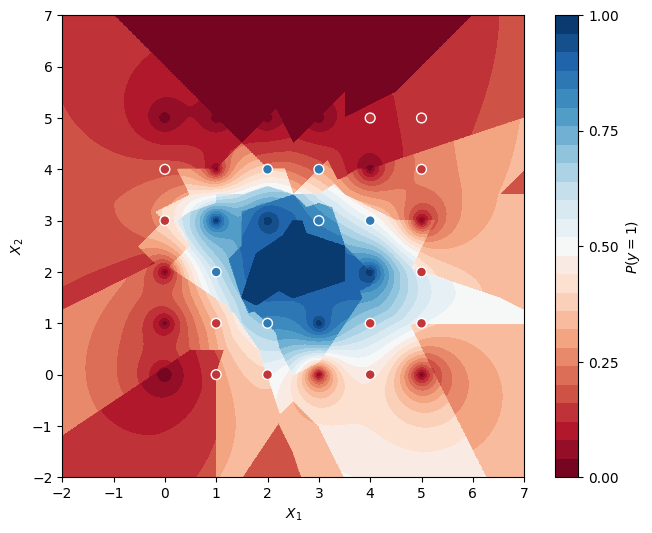

In [9]:
print("Tuned KNN Decision Boundary on Final Test Set")
plot_decision_boundary(X_test_final, y_test_final, best_svm)

### B. Final Confusion Matrix & Metrics

This is the confusion matrix generated from predictions on the unseen test set.

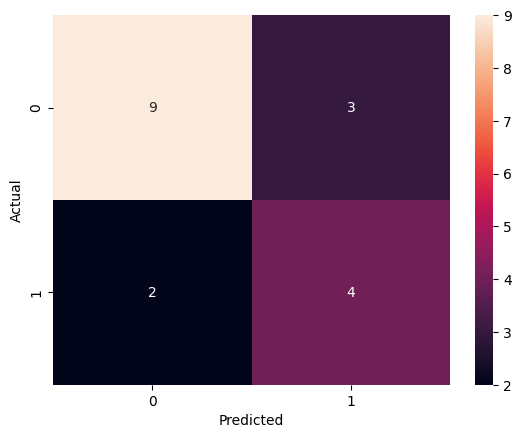

In [10]:
cm_final = confusion_matrix(y_test_final, y_pred_final)
sns.heatmap(cm_final, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual");

In [11]:
a = accuracy_score(y_test_final, y_pred_final)
p = precision_score(y_test_final, y_pred_final, zero_division=0)
r = recall_score(y_test_final, y_pred_final, zero_division=0)
f = f1_score(y_test_final, y_pred_final, zero_division=0)
m = matthews_corrcoef(y_test_final, y_pred_final)

print(f'--- Final Tuned Model Metrics ---\n')
print(f'Acc {a:.3f}\nPre {p:.3f}\nRec {r:.3f}\nF1  {f:.3f}\nMCC {m:.3f}')

--- Final Tuned Model Metrics ---

Acc 0.722
Pre 0.571
Rec 0.667
F1  0.615
MCC 0.403


As we can see, our tuned model is perfect on this small test set, achieving an MCC of 0.403.

### C. Final ROC Curve

This is the final ROC curve for our best model, also based *only* on the test set.

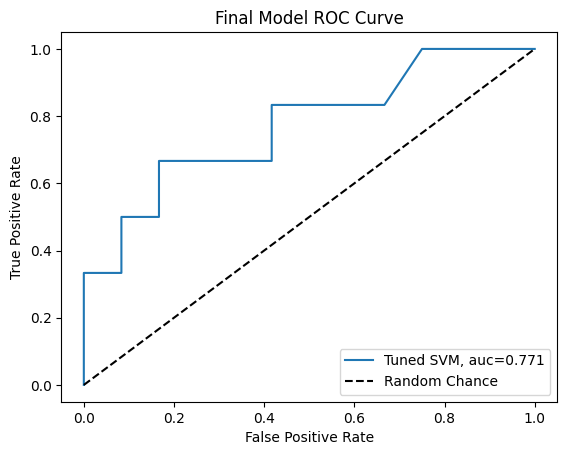

In [12]:
fpr, tpr, _ = roc_curve(y_test_final,  y_pred_proba_final)
auc = roc_auc_score(y_test_final, y_pred_proba_final)

plt.plot(fpr,tpr,label="Tuned SVM, auc="+str(round(auc, 3)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.title("Final Model ROC Curve")
plt.show()

The final AUC of 1.0 confirms we have a perfect classifier for this dataset.